In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.preprocessing as sp
import pickle
import matplotlib.pyplot as plt
import scipy
import os
import time
from datetime import date
# import dask.dataframe as dd
# import dask.config
# dask.config.set({"distributed.scheduler.allowed-failures": 10})
today = date.today()
import os
import sys
sys.path.insert(0, '/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/') 
from singlecell.read import read_single_cell_sql
from singlecell.preprocess import handle_nans, extract_cpfeature_names,find_highly_correlated_features
from singlecell.visualize import visualize_n_SingleCell, cluster
from singlecell.process import statistical_tests,precision_recall
from singlecell.preprocess.filter_out_edge_single_cells import edgeCellFilter
from singlecell.save.save_pandas_dfs import saveDF_to_CSV_GZ_no_timestamp
from singlecell.preprocess.control_for_cellcount import control_feature_y_for_variable_x
from singlecell.process.replicate_correlation import replicate_null_corr_coefs
from singlecell.process import normalize_funcs



DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

In [2]:
########################## Project root directory and path to results ########################
mito_project_root_dir = "/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/"
save_results_dir = mito_project_root_dir + "/workspace/results/jump_fq/"

In [ ]:
# ########## jump_orf/jump_crispr/jump_compound

plates = pd.read_csv(
    mito_project_root_dir + "/workspace/metadata/JUMP/plate.csv.gz"
)
wells = pd.read_csv(
    mito_project_root_dir + "/workspace/metadata/JUMP/well.csv.gz"
)
compound = pd.read_csv(
    mito_project_root_dir + "/workspace/metadata/JUMP/compound.csv.gz"
)
orf = pd.read_csv(
    mito_project_root_dir + "/workspace/metadata/JUMP/orf.csv.gz"
)
crispr = pd.read_csv(
    mito_project_root_dir + "/workspace/metadata/JUMP/crispr.csv.gz"
)

compound_plates = plates[
    plates["Metadata_PlateType"] == "COMPOUND"
].reset_index(drop=True)

dataset = "jump_orf"
annot_orf = wells.merge(orf, on=["Metadata_JCP2022"]).merge(
    plates, on=["Metadata_Plate", "Metadata_Source"]
)
annot_orf["Batch"] = annot_orf["Metadata_Batch"]
annot_orf["batch_plate"] = (
    annot_orf["Metadata_Batch"] + "-" + annot_orf["Metadata_Plate"]
)
annot_orf["ctrl_well"] = annot_orf["Metadata_Symbol"].isin(
    ["LacZ", "BFP", "HcRed", "LUCIFERASE"]
)
annot_orf.to_csv(
    mito_project_root_dir
    + "/workspace/metadata/preprocessed/annot_"
    + dataset
    + ".csv"
)

dataset = "jump_crispr"
annot_crispr = wells.merge(crispr, on=["Metadata_JCP2022"]).merge(
    plates, on=["Metadata_Plate", "Metadata_Source"]
)
annot_compound = wells.merge(compound, on=["Metadata_JCP2022"]).merge(
    compound_plates, on=["Metadata_Plate", "Metadata_Source"]
)

annot_crispr["Batch"] = annot_crispr["Metadata_Batch"]
annot_crispr["batch_plate"] = (
    annot_crispr["Metadata_Batch"] + "-" + annot_crispr["Metadata_Plate"]
)
annot_compound["batch_plate"] = (
    annot_compound["Metadata_Batch"] + "-" + annot_compound["Metadata_Plate"]
)
annot_compound["Batch"] = annot_compound["Metadata_Batch"]

annot_crispr["ctrl_well"] = annot_crispr["Metadata_Symbol"].isin(
    ["non-targeting"]
)
annot_crispr.to_csv(
    mito_project_root_dir
    + "/workspace/metadata/preprocessed/annot_"
    + dataset
    + ".csv"
)

dataset = "jump_compound"
## annot['ctrl_well']=annot['Symbol'].isin(['LacZ'])
annot_compound.to_csv(
    mito_project_root_dir
    + "/workspace/metadata/preprocessed/annot_"
    + dataset
    + ".csv"
)

In [60]:
# # ########## lincs
dataset = "lincs_g"
# annot=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/raw-profiles/CP_LINCS/metadata/matadata_lincs.csv")
annot0 = pd.read_csv(
    mito_project_root_dir
    + "/workspace/metadata/lincs/DrugRepurposing_Metadata.csv"
)
annot = pd.read_csv(
    mito_project_root_dir + "/workspace/metadata/LINCS_meta.csv"
)
annot = annot.merge(
    annot0[["Metadata_Plate", "Metadata_Well", "Metadata_pert_name"]],
    how="left",
    on=["Metadata_Plate", "Metadata_Well"],
)
annot["Batch"] = "2016_04_01_a549_48hr_batch1"
annot["batch_plate"] = annot["Batch"] + "-" + annot["Metadata_Plate"]
annot["Image_Metadata_Well"] = annot["Metadata_Well"]
annot["Image_Metadata_Plate"] = annot["Metadata_Plate"]
annot["ctrl_well"] = annot["Metadata_pert_type"].isin(["control"])
# annot['pert_id']=annot['Metadata_pert_id_dose']
annot.to_csv(
    mito_project_root_dir
    + "/workspace/metadata/preprocessed/annot_"
    + dataset
    + ".csv"
)

In [47]:
import pandas as pd
from sqlalchemy import create_engine
from functools import reduce
import gc


def read_per_well_data(
    input_data_dir,
    annot,
    prof_workspace_folder_name="profiles",
    fformat=".parquet",
):
    batches = annot["Batch"].unique()

    df_agg_all_batches_ls = []
    for b in batches:
        print(b)
        #         if "Metadata_Source" in annot.columns:
        source_str = annot.loc[
            annot["Batch"] == b, "Metadata_Source"
        ].unique()[0]
        #             print(source_str)
        profile_path = (
            input_data_dir
            + source_str
            + "/workspace/"
            + prof_workspace_folder_name
            + "/"
        )
        #         else:
        #             profile_path = input_data_dir + "/workspace/profiles/"

        df_sag_ls = []
        plates_exist = os.listdir(profile_path + b)
        plates_meta = annot.loc[annot["Batch"] == b, "Metadata_Plate"].unique()
        plates = set(plates_meta) & set(plates_exist)
        for p in plates:
            print(p)

            fileName = profile_path + b + "/" + p + "/" + p + fformat
            #             print(fileName)
            if os.path.exists(fileName):
                if fformat == ".parquet":
                    sc_df = pd.read_parquet(fileName)
                elif fformat in [".csv", ".csv.gz"]:
                    sc_df = pd.read_csv(fileName)

                #         per_site_aggregate=sc_df.groupby(['Metadata_Well','Metadata_Site']).mean()[feature_list+['Count_Cells']].reset_index()
                sc_df["Metadata_Batch"] = b
                sc_df["Metadata_Plate"] = p
                df_sag_ls.append(sc_df)
                del sc_df
                gc.collect()
            else:
                print(fileName, " not exists")

        if df_sag_ls:
            df_sag = pd.concat(df_sag_ls, axis=0)
            df_agg_all_batches_ls.append(df_sag)

    df_agg_all_batches = pd.concat(df_agg_all_batches_ls, axis=0)
    return df_agg_all_batches

In [46]:
lincs_meta_cols = [
    "Metadata_broad_sample",
    "Metadata_dose_recode",
    "Metadata_pert_id",
    "Metadata_pert_mfc_id",
    "Metadata_InChIKey14",
    "Metadata_pert_type",
    "Metadata_moa",
    "Metadata_target",
    "Metadata_pert_id_dose",
    "Metadata_pert_name",
]

# lincs_meta_cols=['Metadata_broad_sample','Metadata_dose_recode','Metadata_pert_id','Metadata_pert_mfc_id',\
# 'Metadata_InChIKey14','Metadata_pert_type','Metadata_pert_id_dose']

cdrp_meta_cols = [
    "Metadata_broad_sample",
    "Metadata_mmoles_per_liter2",
    "Metadata_pert_id",
    "Metadata_Sample_Dose",
    "Metadata_moa",
]
jumporf_meta_cols = ["Symbol", "broad_sample"]
jumpcrispr_meta_cols = ["Metadata_NCBI_Gene_ID", "Metadata_Symbol"]
jumpcompound_meta_cols = ["Metadata_InChIKey", "Metadata_InChI"]
taorf_meta_cols = [
    "Metadata_gene_name",
    "Metadata_pert_name",
    "Metadata_broad_sample",
    "Metadata_moa",
]


# jump_orf_params={'profiles_path':"/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/",\
#                  'meta_cols':jumporf_meta_cols,\
#                  'pert_col':'broad_sample',\
#                  'target_features_list':target_features_list_orf_cdrp
#                 }

jump_orf_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0016-jump/",
    "prof_workspace_folder_name": "profiles",
    "pformat": ".parquet",
    "meta_cols": jumporf_meta_cols,
    "pert_col": "Metadata_JCP2022",
    "untreated_key_val": ["Metadata_pert_type", "negcon"],
}

cdrp_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0012-wawer-bioactivecompoundprofiling/broad/workspace/backend/",
    "meta_cols": cdrp_meta_cols,
    "pert_col": "Metadata_Sample_Dose",
}
# /home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace/backend/
# https://cellpainting-gallery.s3.amazonaws.com/cpg0004-lincs/broad/workspace/backend/2016_04_01_a549_48hr_batch1/SQ00014812
lincs_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0004-lincs/",
    "prof_workspace_folder_name": "backend",
    "pformat": ".csv",
    "meta_cols": lincs_meta_cols,
    "pert_col": "Metadata_pert_id_dose",
    "untreated_key_val": ["Metadata_pert_type", "control"],
}

jump_crispr_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0016-jump/",
    "prof_workspace_folder_name": "profiles",
    "pformat": ".parquet",
    "meta_cols": jumpcrispr_meta_cols,
    "pert_col": "Metadata_JCP2022",
    "untreated_key_val": ["Metadata_Symbol", "non-targeting"],
}

jump_compound_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0016-jump/",
    "prof_workspace_folder_name": "profiles",
    "pformat": ".parquet",
    "meta_cols": jumpcompound_meta_cols,
    "pert_col": "Metadata_JCP2022",
    "untreated_key_val": ["Metadata_JCP2022", "JCP2022_999999"],
}

ta_orf_params = {
    "profiles_path": "/home/ubuntu/gallery/cpg0017-rohban-pathways/",
    "prof_workspace_folder_name": "profiles",
    "pformat": ".csv.gz",
    "meta_cols": taorf_meta_cols,
    "pert_col": "Metadata_broad_sample",
    "untreated_key_val": ["Metadata_pert_type", "Untreated"],
}

ds_info_dict = {
    "jump_orf": jump_orf_params,
    "CDRP": cdrp_params,
    "lincs": lincs_params,
    "lincs_g": lincs_params,
    "jump_crispr": jump_crispr_params,
    "jump_compound": jump_compound_params,
    "taorf": ta_orf_params,
}
# 'broad_sample', 'pert_type', 'control_type'

# results=annot[['Symbol','broad_sample', 'pert_type', 'control_type']].drop_duplicates().reset_index(drop=True)

# dataset='CDRP';dataset_meta_hue='Metadata_moa'
# dataset='lincs';dataset_meta_hue='Metadata_moa'
# dataset='jump_orf';dataset_meta_hue='Symbol'

In [ ]:
ls /home/ubuntu/gallery/cpg0017-rohban-pathways/broad/workspace/profiles/2013_10_11_SIGMA2_Pilot

In [28]:
ls 

Batch1_20221004/  Batch3_20221010/  Batch5_20221030/
Batch2_20221006/  Batch4_20221012/  Batch6_20221102/


In [ ]:
annot_crispr["Metadata_Symbol"].unique()

In [ ]:
# annot_crispr.groupby(['Metadata_Batch','Metadata_Source']).size()

In [ ]:
# annot_compound.groupby(['Metadata_Batch','Metadata_Source']).size()

In [ ]:
dataset = "jump_crispr"
dataset = "jump_compound"
dataset = "lincs"
# dataset="taorf"

##################### Read preprocessed metadata
annot = pd.read_csv(
    mito_project_root_dir
    + "/workspace/metadata/preprocessed/annot_"
    + dataset
    + ".csv",
    dtype={"Metadata_Plate": str},
)
annot['Metadata_pert_type']

In [ ]:
annot['Metadata_pert_type'].unique()

In [ ]:
annot[annot["Metadata_JCP2022"] == "JCP2022_999999"].groupby(
    "Metadata_Source"
).size()

## some usefull stats
- jump-orf
   - cp_features: 3578
   - cp_features_analysis/nan cols/low vars: 3419 0 159
   - before dropping nan rows:  (91001, 4607)
   - after dropping nan rows:  (90997, 4607)
   
- jump-compound source 1
   - cp_features: 3673
   - cp_features_analysis/nan cols/low vars: 3392 0 186
   - before dropping nan rows:  (74843, 4580)
   - after dropping nan rows:  (74049, 4580) 
   
   
- taorf   
    - cp_features: 3587
    - len cp_features_analysis/nan cols/low vars: 3362 0 225
    - before dropping nan rows:  (1918, 4436)
    - after dropping nan rows:  (1916, 4436)

In [50]:
df_agg_all_batches.shape, df_sag.shape

((52223, 1787), (52223, 1671))

In [ ]:
    common_cols_2merge = list(set(annot_source.columns) & set(df_sag.columns))
    df_sag["Metadata_Plate"] = df_sag["Metadata_Plate"].astype(str)
    df_sag = pd.merge(df_sag, annot_source, how="inner", on=common_cols_2merge)

In [59]:
# annot_source.shape, df_sag.shape
df_sag.groupby(["Metadata_Plate", "Image_Metadata_Well"]).size()

Metadata_Plate  Image_Metadata_Well
SQ00014812      A01                    1
                A02                    1
                A03                    1
                A04                    1
                A05                    1
                                      ..
SQ00015233      P20                    1
                P21                    1
                P22                    1
                P23                    1
                P24                    1
Length: 52223, dtype: int64

In [58]:
df_sag[["Image_Metadata_Plate", "Metadata_Plate"]]

,Image_Metadata_Plate,Metadata_Plate
0,SQ00015233,SQ00015233
1,SQ00015233,SQ00015233
2,SQ00015233,SQ00015233
3,SQ00015233,SQ00015233
4,SQ00015233,SQ00015233
...,...,...
52218,SQ00015172,SQ00015172
52219,SQ00015172,SQ00015172
52220,SQ00015172,SQ00015172
52221,SQ00015172,SQ00015172


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs
2016_04_01_a549_48hr_batch1
SQ00015233
SQ00015106
SQ00015102
SQ00015098
SQ00015160
SQ00015149
SQ00015221
SQ00015045
SQ00015057
SQ00015230
SQ00015157
SQ00015158
SQ00015116
SQ00015128
SQ00015041
SQ00015054
SQ00015216
SQ00015229
SQ00014814
SQ00015148
SQ00015108
SQ00015124
SQ00015133
SQ00015127
SQ00015144
SQ00015224
SQ00015120
SQ00014816
SQ00015138
SQ00015043
SQ00015210
SQ00015052
SQ00015155
SQ00015051
SQ00015167
SQ00015122
SQ00014815
SQ00015132
SQ00015203
SQ00015107
SQ00015150
SQ00015048
SQ00015171
SQ00015218
SQ00015162
SQ00015136
SQ00015170
SQ00015123
SQ00015053
SQ00015143
SQ00015047
SQ00015168
SQ00015220
SQ00015164
SQ00015206
SQ00015117
SQ00015096
SQ00015145
SQ00015222
SQ00015137
SQ00015059
SQ00015211
SQ00015196
SQ00015131
SQ00015153
SQ00015232
SQ00014820
SQ00015101
SQ00015112
SQ00015147
SQ00015042
SQ00015105
SQ00015121
SQ00015154
SQ00015208
SQ00015135
SQ00015223
SQ00015129
SQ00015212
SQ00015197
SQ00015111
SQ00015204
SQ0001

<IPython.core.display.Javascript object>


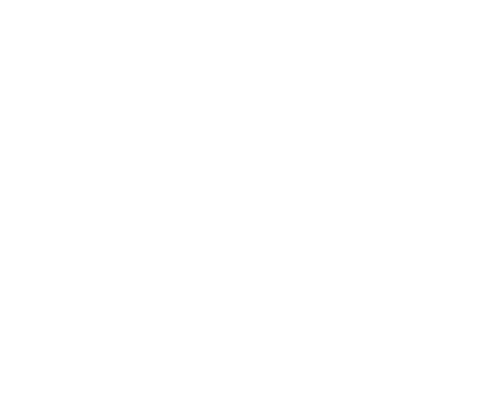

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [61]:
%time

# dataset = "jump_orf"
# dataset='CDRP'
# dataset='lincs'
# dataset="jump_crispr"
# dataset = "jump_compound"
dataset = "lincs_g"

##################### Read preprocessed metadata
annot = pd.read_csv(
    mito_project_root_dir
    + "/workspace/metadata/preprocessed/annot_"
    + dataset
    + ".csv",
    dtype={"Metadata_Plate": str},
)

# annot = annot[annot["Metadata_Batch"] == "2021_04_26_Batch1"].reset_index(
#     drop=True
# )

# target_features_list = ds_info_dict[dataset]["target_features_list"]

if "Metadata_Source" not in annot.columns:
    annot["Metadata_Source"] = "broad"

sources = annot["Metadata_Source"].unique()
for si in sources:
    annot_source = annot[annot["Metadata_Source"] == si].reset_index()

    ##################### Read per well data
    #     if dataset in [
    #         "lincs",
    #         "lincs_g",
    #         "taorf",
    #     ]:  # for this batch of lincs data we dont have well level profiles
    #         df_agg_all_batches = sample_single_cells_from_sql(
    #             ds_info_dict[dataset]["profiles_path"], annot_source
    #         )
    df_agg_all_batches = read_per_well_data(
        ds_info_dict[dataset]["profiles_path"],
        annot_source,
        ds_info_dict[dataset]["prof_workspace_folder_name"],
        fformat=ds_info_dict[dataset]["pformat"],
    )
    #     else:
    #         #     df_agg_all_batches=read_per_well_data_csvs(ds_info_dict[dataset]["profiles_path"],annot);
    #         df_agg_all_batches = read_per_well_data(
    #             ds_info_dict[dataset]["profiles_path"],
    #             annot_source,
    #             ds_info_dict[dataset]["prof_workspace_folder_name"],
    #             fformat=".parquet",
    #         )

    ##################### Clean and shrink features
    (
        cp_features,
        cp_features_analysis_0,
    ) = extract_cpfeature_names.extract_cpfeature_names(df_agg_all_batches)
    df_sag, cp_features_analysis = handle_nans.handle_nans(
        df_agg_all_batches,
        cp_features_analysis_0,
        thrsh_null_ratio=0.05,
        thrsh_std=0.001,
        fill_na_method="drop-rows",
    )

    ##################### merge all aggregated profiles with annot
    common_cols_2merge = list(set(annot_source.columns) & set(df_sag.columns))
    df_sag["Metadata_Plate"] = df_sag["Metadata_Plate"].astype(str)
    df_sag = pd.merge(df_sag, annot_source, how="inner", on=common_cols_2merge)

    ##################### normalize to negative control
    if 0:
        df_sag_zscored = normalize_funcs.zscore_df_columns_by_control_perPlate(
            df_sag,
            cp_features_analysis,
            "Standard",
            "batch_plate",
            ds_info_dict[dataset]["untreated_key_val"],
        )

        df_sag_zscored = df_sag_zscored[
            ds_info_dict[dataset]["untreated_key_val"][0]
            != ds_info_dict[dataset]["untreated_key_val"][1]
        ].reset_index()
    else:
        df_sag_zscored = df_sag.copy()

    ##################### per plate standardization
    df_rep_level_scaled = normalize_funcs.standardize_per_catX(
        df_sag_zscored, "batch_plate", cp_features_analysis
    ).copy()

    df_rep_level_scaled = df_rep_level_scaled[
        df_rep_level_scaled[ds_info_dict[dataset]["untreated_key_val"][0]]
        != ds_info_dict[dataset]["untreated_key_val"][1]
    ].reset_index()

    ##################### calculate and save replication correlatiopn curves
    pert_col = ds_info_dict[dataset]["pert_col"]
    nOfReps = df_rep_level_scaled.groupby([pert_col]).size().reset_index()
    pairWithReplicates = nOfReps.loc[nOfReps[0] != 1, :].reset_index()[
        pert_col
    ]  # .groupby([0]).size()

    df_rep_level_scaled[cp_features_analysis] = df_rep_level_scaled[
        cp_features_analysis
    ].astype("float32")

    df_rep_level_scaled.to_csv(
        save_results_dir
        + "/preprocessed_data/"
        + dataset
        + "_df_rep_level_scaled_"
        + si
        + ".csv",
        index=False,
    )

    if 1:
        fh_2save, repCorrDf = replicate_null_corr_coefs(
            df_rep_level_scaled[
                df_rep_level_scaled[pert_col].isin(pairWithReplicates)
            ].reset_index(drop=True),
            pert_col,
            cp_features_analysis,
            1,
            title="",
            hist_bins=50,
        )

        fh_2save.savefig(
            save_results_dir
            + "/corr_curves/"
            + dataset
            + "_corr_curves_"
            + si
            + ".png"
        )
        repCorrDf.to_csv(
            save_results_dir
            + "/corr_csvs/"
            + dataset
            + "_corr_df_"
            + si
            + ".csv",
            index=False,
        )

    ##################### calculate and save feature quality rannkings
    #     df_rep_level_scaled2 = (
    #         df_rep_level_scaled.groupby([pert_col, "batch_plate"])
    #         .mean()
    #         .reset_index()
    #     )

    df_rep_level_scaled2 = df_rep_level_scaled[
        df_rep_level_scaled[pert_col].isin(pairWithReplicates)
    ].reset_index(drop=True)

    DS_featureQ_rank = pd.DataFrame(
        data=df_rep_level_scaled2.groupby(pert_col)
        .std()
        .mean()[cp_features_analysis],
        index=cp_features_analysis,
        columns=["average_std_score"],
    )

    batches = annot_source["Batch"].unique()
    for b in batches:
        df_rep_per_batch = df_rep_level_scaled2[
            df_rep_level_scaled2["Batch"] == b
        ].reset_index(drop=True)
        nOfReps = df_rep_per_batch.groupby([pert_col]).size().reset_index()
        pairWithReplicates_batch = nOfReps.loc[
            nOfReps[0] != 1, :
        ].reset_index()[pert_col]
        df_rep_per_batch2 = df_rep_per_batch[
            df_rep_per_batch[pert_col].isin(pairWithReplicates_batch)
        ].reset_index(drop=True)

        DS_featureQ_rank["average_std_score_" + b] = (
            df_rep_per_batch2.groupby(pert_col)
            .std()
            .mean()[cp_features_analysis]
        )

    DS_featureQ_rank2 = (
        DS_featureQ_rank.sort_values(by="average_std_score", ascending=True)
        .reset_index()
        .rename(columns={"index": "features"})
    )

    DS_featureQ_rank2.to_csv(
        save_results_dir
        + "/fq_csvs/"
        + dataset
        + "_feature_quality_"
        + si
        + ".csv",
        index=False,
    )

In [45]:
ls /home/ubuntu/gallery/cpg0004-lincs/broad/workspace/backend/2016_04_01_a549_48hr_batch1/SQ00015210/

SQ00015210.csv*  SQ00015210.sqlite*


In [72]:
ls /home/ubuntu/gallery/cpg0017-rohban-pathways/broad/workspace/profiles/2013_10_11_SIGMA2_Pilot/41744

41744_augmented.csv.gz*      41744_normalized.csv.gz*
41744_augmented.csv.gz.dvc*  41744_normalized.csv.gz.dvc*
41744.csv.gz*                41744_normalized_feature_select_batch.csv.gz*
41744.csv.gz.dvc*            41744_normalized_feature_select_batch.csv.gz.dvc*


In [33]:
ls /home/ubuntu/gallery/cpg0004-lincs/broad/workspace/backend/2016_04_01_a549_48hr_batch1/SQ00014814

SQ00014814.csv*  SQ00014814.sqlite*


In [8]:
df_rep_level_scaled.to_csv(
    save_results_dir
    + "/preprocessed_data/"
    + dataset
    + "_df_rep_level_scaled_"
    + si
    + ".csv",
    index=False,
)

In [ ]:
# dataset = "jump_orf"
# dataset='CDRP'
dataset='lincs'
# dataset="jump_crispr"
# dataset = "jump_compound"
# dataset="taorf"

##################### Read preprocessed metadata
annot = pd.read_csv(
    mito_project_root_dir
    + "/workspace/metadata/preprocessed/annot_"
    + dataset
    + ".csv",
    dtype={"Metadata_Plate": str},
)

df_rep_level_scaled2 = df_rep_level_scaled[
    df_rep_level_scaled[pert_col].isin(pairWithReplicates)
].reset_index(drop=True)

DS_featureQ_rank = pd.DataFrame(
    data=df_rep_level_scaled2.groupby(pert_col)
    .std()
    .mean()[cp_features_analysis],
    index=cp_features_analysis,
    columns=["average_std_score"],
)

batches = annot_source["Batch"].unique()
for b in batches:
    df_rep_per_batch = df_rep_level_scaled2[
        df_rep_level_scaled2["Batch"] == b
    ].reset_index(drop=True)
    nOfReps = df_rep_per_batch.groupby([pert_col]).size().reset_index()
    pairWithReplicates_batch = nOfReps.loc[
        nOfReps[0] != 1, :
    ].reset_index()[pert_col]
    df_rep_per_batch2 = df_rep_per_batch[
        df_rep_per_batch[pert_col].isin(pairWithReplicates_batch)
    ].reset_index(drop=True)

    DS_featureQ_rank["average_std_score_" + b] = (
        df_rep_per_batch2.groupby(pert_col)
        .std()
        .mean()[cp_features_analysis]
    )

DS_featureQ_rank2 = (
    DS_featureQ_rank.sort_values(by="average_std_score", ascending=True)
    .reset_index()
    .rename(columns={"index": "features"})
)

DS_featureQ_rank2.to_csv(
    save_results_dir + "/fq_csvs/" + dataset + "_feature_quality_" + si + ".csv",
    index=False,
)

In [ ]:
df_rep_level_scaled[
    df_rep_level_scaled[ds_info_dict[dataset]["untreated_key_val"][0]]
    == ds_info_dict[dataset]["untreated_key_val"][1]
]

In [ ]:
df_rep_level_scaled[
    df_rep_level_scaled[pert_col].isin(pairWithReplicates)
].reset_index(drop=True).groupby("Metadata_JCP2022").size().sort_values()

In [ ]:
reshaped_feature_rep_level_ddf = dd.from_pandas(
    reshaped_feature_rep_level_df, npartitions=10
)


DS_featureQ_rank = (
    reshaped_feature_rep_level_ddf.groupby("features")
    .std()
    .mean(axis=1)
    .reset_index()
    .sort_values(by=0, ascending=True)
    .reset_index(drop=True)
)

DS_featureQ_rank.compute()

## Read feature quality scores and make plots

<IPython.core.display.Javascript object>


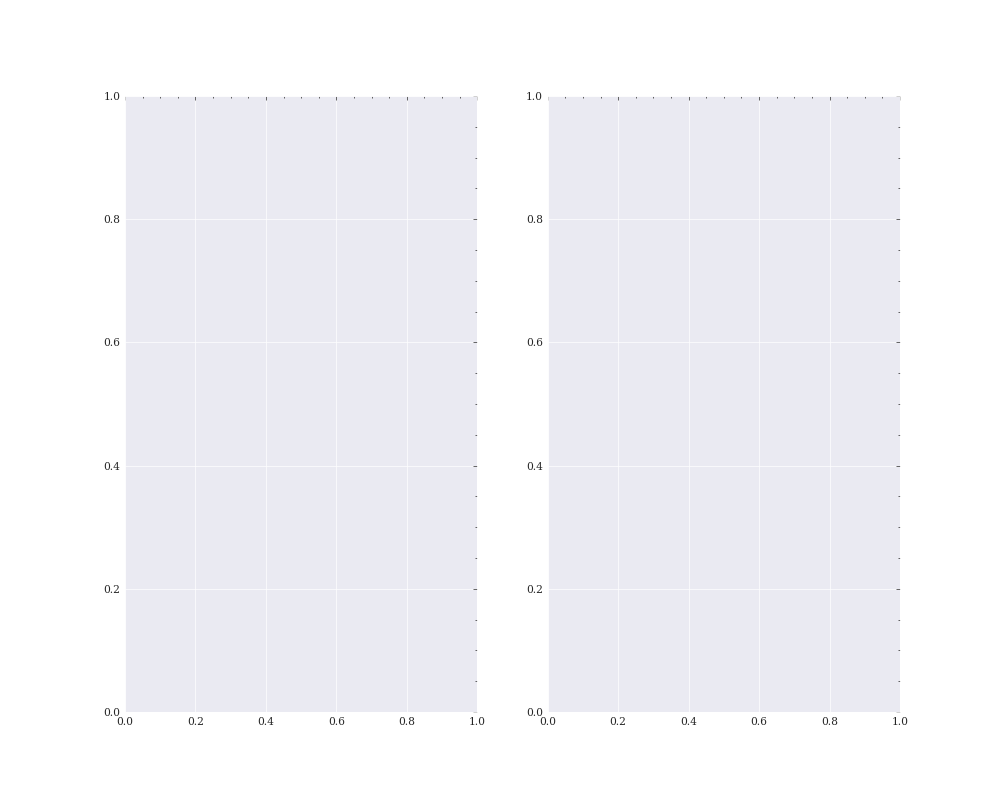

ValueError: The number of observations cannot be determined on an empty distance matrix.

In [65]:
import scienceplots

plt.style.use(["science", "no-latex"])
# dataset = "jump_orf"
# dataset='CDRP'
# dataset = "lincs_g"
dataset="jump_crispr"
# dataset = "jump_compound"
# dataset="taorf"

##################### Read preprocessed metadata
annot = pd.read_csv(
    mito_project_root_dir
    + "/workspace/metadata/preprocessed/annot_"
    + dataset
    + ".csv",
    dtype={"Metadata_Plate": str},
)


if "Metadata_Source" not in annot.columns:
    annot["Metadata_Source"] = "broad"

# target_features_list = ds_info_dict[dataset]["target_features_list"]
# sources = ['source_5']
sources = annot["Metadata_Source"].unique()
for si in sources:
    DS_X_featureQ_rank_df = pd.read_csv(
        save_results_dir
        + "/fq_csvs/"
        + dataset
        + "_feature_quality_"
        + si
        + ".csv"
    )

    batch_names_cols = DS_X_featureQ_rank_df.columns[
        DS_X_featureQ_rank_df.columns.str.contains("^average_std_score_")
    ].tolist()
    #     DS_X_featureQ_rank_df= normalize_funcs.standardize_df_columns(DS_X_featureQ_rank_df, batch_names_cols, 'Standard')

    f = cluster.check_feature_similarity_dendrogram(
        DS_X_featureQ_rank_df, batch_names_cols, (10, 8)
    )
    f.suptitle(si)
#     annot_source = annot[annot["Metadata_Source"] == si].reset_index()

## Cross dataset feature quality match

In [66]:
from functools import reduce
import scienceplots

plt.style.use(["science", "no-latex"])

datasets = ["jump_crispr", "jump_compound", "jump_orf", "taorf", "lincs_g"]
df_ls = []
# names=[]
for dataset in datasets:
    #     names.append(dataset)
    annot = pd.read_csv(
        mito_project_root_dir
        + "/workspace/metadata/preprocessed/annot_"
        + dataset
        + ".csv",
        dtype={"Metadata_Plate": str},
    )
    if "Metadata_Source" not in annot.columns:
        annot["Metadata_Source"] = "broad"
    # target_features_list = ds_info_dict[dataset]["target_features_list"]
    # sources = ['source_5']
    sources = annot["Metadata_Source"].unique()
    for si in sources:
        file_path = (
            save_results_dir
            + "/fq_csvs/"
            + dataset
            + "_feature_quality_"
            + si
            + ".csv"
        )

        if os.path.exists(file_path):
            DS_X_featureQ_rank_df = pd.read_csv(file_path)

        #         batch_names_cols = DS_X_featureQ_rank_df.columns[
        #             DS_X_featureQ_rank_df.columns.str.contains("^average_std_score_")
        #         ].tolist()
        df_ls.append(
            DS_X_featureQ_rank_df[["features", "average_std_score"]].rename(
                columns={
                    "average_std_score": "average_std_score_"
                    + dataset
                    + "_"
                    + si
                }
            )
        )
all_datasets_df = reduce(
    lambda left, right: pd.merge(left, right, on="features", how="inner"),
    df_ls,
)

ds_names_cols = all_datasets_df.columns[
    all_datasets_df.columns.str.contains("^average_std_score_")
]
f = cluster.check_feature_similarity_dendrogram(
    all_datasets_df, ds_names_cols, (10, 8)
)

,features,average_std_score,average_std_score_2016_04_01_a549_48hr_batch1
0,Nuclei_Intensity_MADIntensity_Mito,0.051203,0.051203
1,Cells_Neighbors_SecondClosestDistance_10,0.052554,0.052554
2,Cells_Neighbors_SecondClosestDistance_Adjacent,0.052554,0.052554
3,Nuclei_Neighbors_SecondClosestDistance_2,0.054687,0.054687
4,Cells_Correlation_Manders_DNA_RNA,0.060483,0.060483
...,...,...,...
1547,Cells_AreaShape_Center_X,0.681821,0.681821
1548,Cytoplasm_Location_Center_X,0.681924,0.681924
1549,Cells_Location_Center_X,0.682057,0.682057
1550,Nuclei_Location_Center_X,0.683005,0.683005


In [30]:
cp.columns[cp.columns.str.contains("Mito|mito")]

Text(0.5, 0.98, 'd')

## Does any categories consistantly show high or low quality?

In [ ]:
Channelss = ["DNA", "RNA", "AGP", "Mito|mito", "ER"]
featureGroups = ["Texture", "Intensity", "RadialDistribution"]

all_datasets_df["across_ds_median_score"] = all_datasets_df[
    ds_names_cols
].median(axis=1)

cp = all_datasets_df.set_index("features").T
# relationMat_mpCat=pd.DataFrame(index=l1k_features)
for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):
        #         print(ch, f)

        selectedCols = cp.columns[
            cp.columns.str.contains(Channelss[ch])
            & cp.columns.str.contains(featureGroups[f])
            & cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")
        ].tolist()
        if selectedCols != []:
            all_datasets_df.loc[
                all_datasets_df["features"].isin(selectedCols),
                ["group", "channel", "family"],
            ] = (
                Channelss[ch] + "_" + featureGroups[f],
                Channelss[ch],
                featureGroups[f],
            )

Channelss = ["Nuclei", "Cytoplasm", "Cells"]
featureGroups = ["AreaShape"]

for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):
        #         print(ch, f)
        selectedCols = cp.columns[
            cp.columns.str.contains(Channelss[ch])
            & cp.columns.str.contains(featureGroups[f])
            & cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")
        ].tolist()
        if selectedCols != []:
            all_datasets_df.loc[
                all_datasets_df["features"].isin(selectedCols),
                ["group", "channel", "family"],
            ] = (
                Channelss[ch] + "_" + featureGroups[f],
                Channelss[ch],
                featureGroups[f],
            )


################## PLOT
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate medians and sort by them
medians = (
    all_datasets_df.groupby("group")["across_ds_median_score"]
    .median()
    .sort_values(ascending=True)
)
sorted_groups = medians.index
plt.figure(figsize=(8, 8))
# Plot
sns.boxplot(
    x="group",
    y="across_ds_median_score",
    data=all_datasets_df,
    order=sorted_groups,
)

plt.title("Boxplot of across_ds_median_score for Each Group")
plt.xlabel("Group")
plt.ylabel("Across DS Median Score")

# Rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

## Cross-Dataset feature profile match
- "jump_orf", "jump_crispr", "taorf"

overlap_symbols size:  126 overlap_features size:  3302


<IPython.core.display.Javascript object>


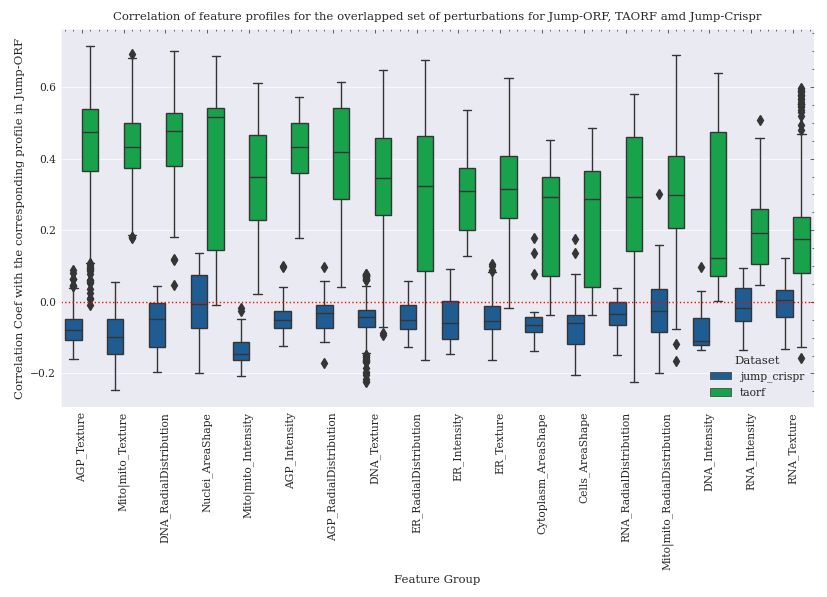

In [178]:
from functools import reduce
import scienceplots

plt.style.use(["science", "no-latex"])

datasets = ["jump_orf", "jump_crispr", "taorf"]

symbol_col = {
    "jump_crispr": "Metadata_Symbol",
    "jump_orf": "Metadata_Symbol",
    "taorf": "Metadata_gene_name",
}

df_ls = []
# names=[]
ds_symbols = {}
ds_features = {}
for dataset in datasets:
    #     names.append(dataset)
    annot = pd.read_csv(
        mito_project_root_dir
        + "/workspace/metadata/preprocessed/annot_"
        + dataset
        + ".csv",
        dtype={"Metadata_Plate": str},
    )
    if "Metadata_Source" not in annot.columns:
        annot["Metadata_Source"] = "broad"
    # target_features_list = ds_info_dict[dataset]["target_features_list"]
    # sources = ['source_5']
    sources = annot["Metadata_Source"].unique()
    for si in sources:
        file_path = (
            save_results_dir
            + "/preprocessed_data/"
            + dataset
            + "_df_rep_level_scaled_"
            + si
            + ".csv"
        )
        if os.path.exists(file_path):
            df_rep_level_scaled = pd.read_csv(file_path)

            ds_symbols[dataset] = (
                df_rep_level_scaled[symbol_col[dataset]].unique().tolist()
            )

            (
                cp_features,
                cp_features_analysis_0,
            ) = extract_cpfeature_names.extract_cpfeature_names(
                df_rep_level_scaled
            )

            ds_features[dataset] = cp_features_analysis_0

            #         batch_names_cols = DS_X_featureQ_rank_df.columns[
            #             DS_X_featureQ_rank_df.columns.str.contains("^average_std_score_")
            #         ].tolist()
            df_ls.append(df_rep_level_scaled)
        else:
            cvdsvcxvx


overlap_symbols = list(
    set.intersection(*(set(values) for values in ds_symbols.values()))
)

overlap_features = list(
    set.intersection(*(set(values) for values in ds_features.values()))
)

print(
    "overlap_symbols size: ",
    len(overlap_symbols),
    "overlap_features size: ",
    len(overlap_features),
)

ref_ds_name = "jump_orf"
ref_df = (
    df_ls[0]
    .loc[
        df_ls[0][symbol_col[ref_ds_name]].isin(overlap_symbols),
        [symbol_col[ref_ds_name]] + overlap_features,
    ]
    .reset_index(drop=True)
    .groupby(symbol_col[ref_ds_name])
    .mean()
)


cc_df_ls = []
for i, ds in enumerate(["jump_crispr", "taorf"]):
    tar_df = (
        df_ls[i + 1]
        .loc[
            df_ls[i + 1][symbol_col[ds]].isin(overlap_symbols),
            [symbol_col[ds]] + overlap_features,
        ]
        .reset_index(drop=True)
        .groupby(symbol_col[ds])
        .mean()
    )

    x = ref_df.corrwith(tar_df).reset_index(name="cc")
    x["Dataset"] = ds
    cc_df_ls.append(x)


cc_df_res = pd.concat(cc_df_ls, axis=0).rename(columns={"index": "features"})

###################
Channelss = ["DNA", "RNA", "AGP", "Mito|mito", "ER"]
featureGroups = ["Texture", "Intensity", "RadialDistribution"]

# all_datasets_df["across_ds_median_score"] = all_datasets_df[
#     ds_names_cols
# ].median(axis=1)

cp = cc_df_res.set_index("features").T
# relationMat_mpCat=pd.DataFrame(index=l1k_features)
for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):
        #         print(ch, f)

        selectedCols = cp.columns[
            cp.columns.str.contains(Channelss[ch])
            & cp.columns.str.contains(featureGroups[f])
            & cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")
        ].tolist()
        if selectedCols != []:
            cc_df_res.loc[
                cc_df_res["features"].isin(selectedCols),
                ["group", "channel", "family"],
            ] = (
                Channelss[ch] + "_" + featureGroups[f],
                Channelss[ch],
                featureGroups[f],
            )

Channelss = ["Nuclei", "Cytoplasm", "Cells"]
featureGroups = ["AreaShape"]

for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):
        #         print(ch, f)
        selectedCols = cp.columns[
            cp.columns.str.contains(Channelss[ch])
            & cp.columns.str.contains(featureGroups[f])
            & cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")
        ].tolist()
        if selectedCols != []:
            cc_df_res.loc[
                cc_df_res["features"].isin(selectedCols),
                ["group", "channel", "family"],
            ] = (
                Channelss[ch] + "_" + featureGroups[f],
                Channelss[ch],
                featureGroups[f],
            )


################## PLOT
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

sorted_groups = (
    group_medians.unstack(level="Dataset")
    .diff(axis=1)
    .sort_values(by="taorf", ascending=False)
    .index.tolist()
)

# Plot
sns.boxplot(
    x="group",
    y="cc",
    data=cc_df_res,
    hue="Dataset",
    order=sorted_groups,
)

plt.axhline(y=0, color="red", linestyle="dotted")
plt.title(
    "Correlation of feature profiles for the overlapped set of perturbations for Jump-ORF, TAORF amd Jump-Crispr"
)
plt.xlabel("Feature Group")
plt.ylabel("Correlation Coef with the corresponding profile in Jump-ORF")

# Rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

- jump-compound and lincs

In [179]:
from functools import reduce
import scienceplots

plt.style.use(["science", "no-latex"])

datasets = ["jump_compound", "lincs_g"]

symbol_col = {
    "jump_compound": "Metadata_Symbol",
    "lincs_g": "Metadata_Symbol",
}

df_ls = []
# names=[]
ds_symbols = {}
ds_features = {}
for dataset in datasets:
    #     names.append(dataset)
    annot = pd.read_csv(
        mito_project_root_dir
        + "/workspace/metadata/preprocessed/annot_"
        + dataset
        + ".csv",
        dtype={"Metadata_Plate": str},
    )
    if "Metadata_Source" not in annot.columns:
        annot["Metadata_Source"] = "broad"
    # target_features_list = ds_info_dict[dataset]["target_features_list"]
    # sources = ['source_5']
    sources = annot["Metadata_Source"].unique()
    for si in sources:
        file_path = (
            save_results_dir
            + "/preprocessed_data/"
            + dataset
            + "_df_rep_level_scaled_"
            + si
            + ".csv"
        )
        if os.path.exists(file_path):
            df_rep_level_scaled = pd.read_csv(file_path)
            fsssfdf
            ds_symbols[dataset] = (
                df_rep_level_scaled[symbol_col[dataset]].unique().tolist()
            )

            (
                cp_features,
                cp_features_analysis_0,
            ) = extract_cpfeature_names.extract_cpfeature_names(
                df_rep_level_scaled
            )

            ds_features[dataset] = cp_features_analysis_0

            #         batch_names_cols = DS_X_featureQ_rank_df.columns[
            #             DS_X_featureQ_rank_df.columns.str.contains("^average_std_score_")
            #         ].tolist()
            df_ls.append(df_rep_level_scaled)
        else:
            cvdsvcxvx


overlap_symbols = list(
    set.intersection(*(set(values) for values in ds_symbols.values()))
)

overlap_features = list(
    set.intersection(*(set(values) for values in ds_features.values()))
)

print(
    "overlap_symbols size: ",
    len(overlap_symbols),
    "overlap_features size: ",
    len(overlap_features),
)

ref_ds_name = "jump_compound"
ref_df = (
    df_ls[0]
    .loc[
        df_ls[0][symbol_col[ref_ds_name]].isin(overlap_symbols),
        [symbol_col[ref_ds_name]] + overlap_features,
    ]
    .reset_index(drop=True)
    .groupby(symbol_col[ref_ds_name])
    .mean()
)


cc_df_ls = []
for i, ds in enumerate(["lincs_g"]):
    tar_df = (
        df_ls[i + 1]
        .loc[
            df_ls[i + 1][symbol_col[ds]].isin(overlap_symbols),
            [symbol_col[ds]] + overlap_features,
        ]
        .reset_index(drop=True)
        .groupby(symbol_col[ds])
        .mean()
    )

    x = ref_df.corrwith(tar_df).reset_index(name="cc")
    x["Dataset"] = ds
    cc_df_ls.append(x)


cc_df_res = pd.concat(cc_df_ls, axis=0).rename(columns={"index": "features"})

###################
Channelss = ["DNA", "RNA", "AGP", "Mito|mito", "ER"]
featureGroups = ["Texture", "Intensity", "RadialDistribution"]

# all_datasets_df["across_ds_median_score"] = all_datasets_df[
#     ds_names_cols
# ].median(axis=1)

cp = cc_df_res.set_index("features").T
# relationMat_mpCat=pd.DataFrame(index=l1k_features)
for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):
        #         print(ch, f)

        selectedCols = cp.columns[
            cp.columns.str.contains(Channelss[ch])
            & cp.columns.str.contains(featureGroups[f])
            & cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")
        ].tolist()
        if selectedCols != []:
            cc_df_res.loc[
                cc_df_res["features"].isin(selectedCols),
                ["group", "channel", "family"],
            ] = (
                Channelss[ch] + "_" + featureGroups[f],
                Channelss[ch],
                featureGroups[f],
            )

Channelss = ["Nuclei", "Cytoplasm", "Cells"]
featureGroups = ["AreaShape"]

for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):
        #         print(ch, f)
        selectedCols = cp.columns[
            cp.columns.str.contains(Channelss[ch])
            & cp.columns.str.contains(featureGroups[f])
            & cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")
        ].tolist()
        if selectedCols != []:
            cc_df_res.loc[
                cc_df_res["features"].isin(selectedCols),
                ["group", "channel", "family"],
            ] = (
                Channelss[ch] + "_" + featureGroups[f],
                Channelss[ch],
                featureGroups[f],
            )


################## PLOT
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

sorted_groups = (
    group_medians.unstack(level="Dataset")
    .diff(axis=1)
    .sort_values(by="taorf", ascending=False)
    .index.tolist()
)

# Plot
sns.boxplot(
    x="group",
    y="cc",
    data=cc_df_res,
    hue="Dataset",
    order=sorted_groups,
)

plt.axhline(y=0, color="red", linestyle="dotted")
plt.title(
    "Correlation of feature profiles for the overlapped set of perturbations for Jump-ORF, TAORF amd Jump-Crispr"
)
plt.xlabel("Feature Group")
plt.ylabel("Correlation Coef with the corresponding profile in Jump-ORF")

# Rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

NameError: name 'fsssfdf' is not defined

In [186]:
df_rep_level_scaled[
    df_rep_level_scaled.columns[
        df_rep_level_scaled.columns.str.contains("Metada")
    ]
]

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_PlateType
0,source_1,UL000081,A02,Batch4_20221012,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,COMPOUND
1,source_1,UL000081,A03,Batch4_20221012,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,COMPOUND
2,source_1,UL000081,A04,Batch4_20221012,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,COMPOUND
3,source_1,UL000081,A05,Batch4_20221012,JCP2022_047857,KYVAFSAMGPNOIA-UHFFFAOYSA-N,InChI=1S/C23H18FNO4S/c1-2-10-29-16-5-3-4-14(11...,COMPOUND
4,source_1,UL000081,A06,Batch4_20221012,JCP2022_072229,QAVAMIPQKRZGGW-UHFFFAOYSA-N,InChI=1S/C19H24N2O5/c1-5-21(19(22)12-6-7-12)11...,COMPOUND
...,...,...,...,...,...,...,...,...
74044,source_1,UL001781,Z43,Batch5_20221030,JCP2022_064404,OKPPTOAERRHVKW-UHFFFAOYSA-N,InChI=1S/C21H25NO2/c1-22(18-7-3-2-4-8-18)15-16...,COMPOUND
74045,source_1,UL001781,Z44,Batch5_20221030,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,COMPOUND
74046,source_1,UL001781,Z45,Batch5_20221030,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,COMPOUND
74047,source_1,UL001781,Z46,Batch5_20221030,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,COMPOUND


In [152]:
sources = annot["Metadata_Source"].unique()

In [169]:
Metadata_JCP2022